In [154]:
import numpy as np
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
import keras_tuner
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from keras.utils import np_utils
import pandas as pd
import copy
import seaborn as sb
from sklearn.impute import KNNImputer

# Suppressing DeprecationWarnings from KerasRegressor - not yet using the new SciKeras version
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

First we import all the data and begin with an initial high level look at the data to get a feel for the problem, and possible identify some cleaning steps that need to be taken. We will search for missing data in the form of NaN values, and plot the distributions of all features as well as their relationships with the corresponding target variable.

In [219]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

y_train0 = train['y']
X_train0 = train.drop(columns='y')

y_test0 = test['y']
X_test0 = test.drop(columns='y')

X_train0.head()

print(f'{X_train0.isna().sum().sum()} NaN values found')
print(f'{X_train0.duplicated().sum()} duplicated rows found')

0 NaN values found
0 duplicated rows found


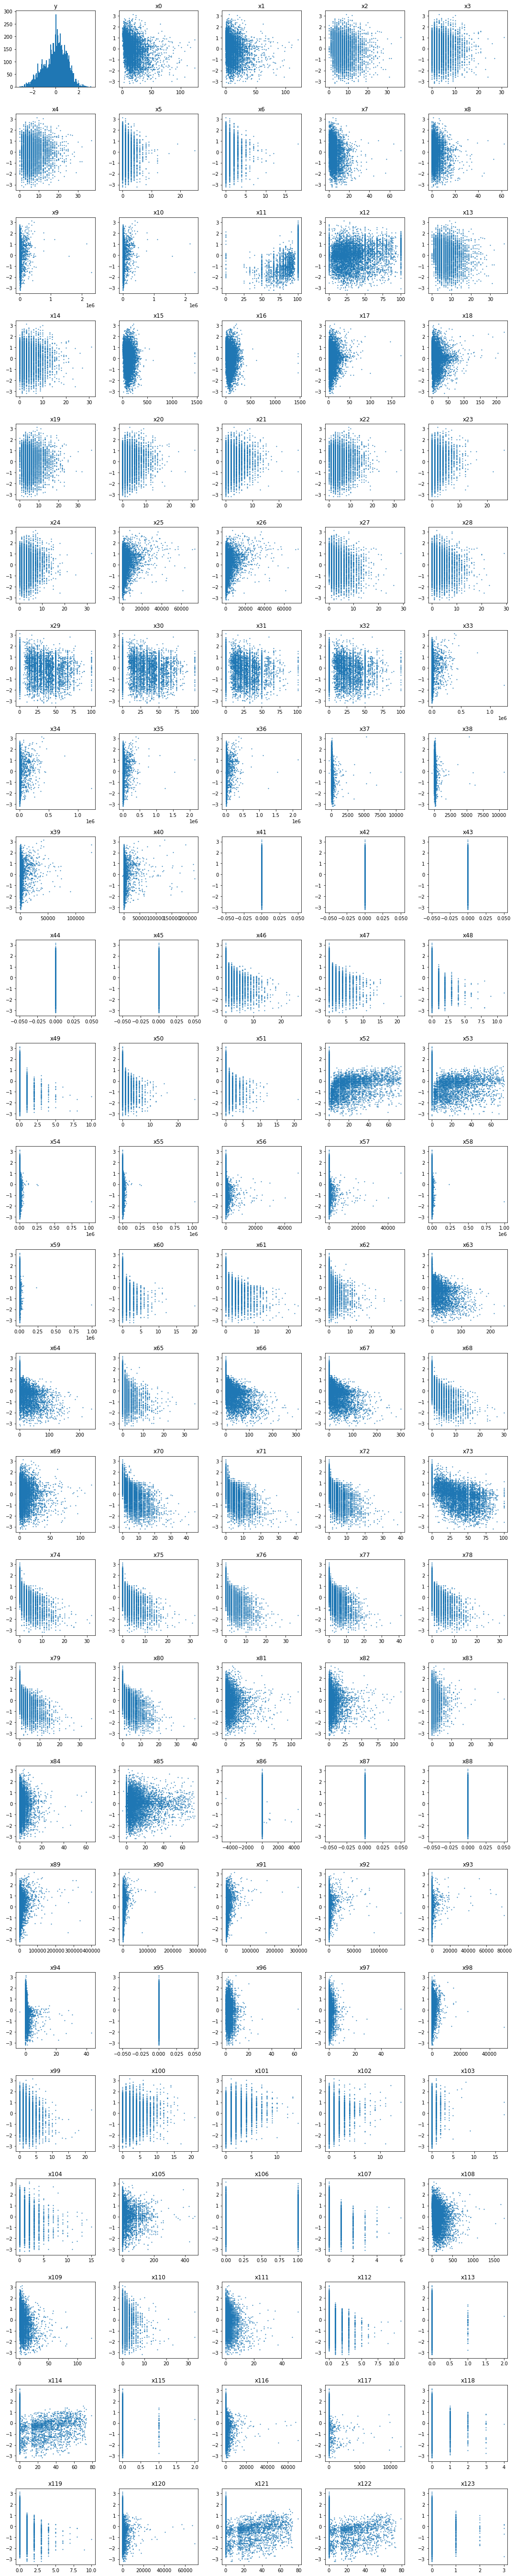

In [167]:
# Display all features vs y
fig, ax = plt.subplots(nrows=25, ncols=5, figsize=(15,75))

ax = ax.reshape(-1)
for i in range(np.size(ax)):
    if i == 0:
        ax[i].hist(y_train0,bins=100)
        ax[i].set_title('y')
    else:
        ax[i].scatter(X_train0[f'x{i-1}'],y_train0, s=1)
        ax[i].set_title(f'x{i-1}')

plt.tight_layout()

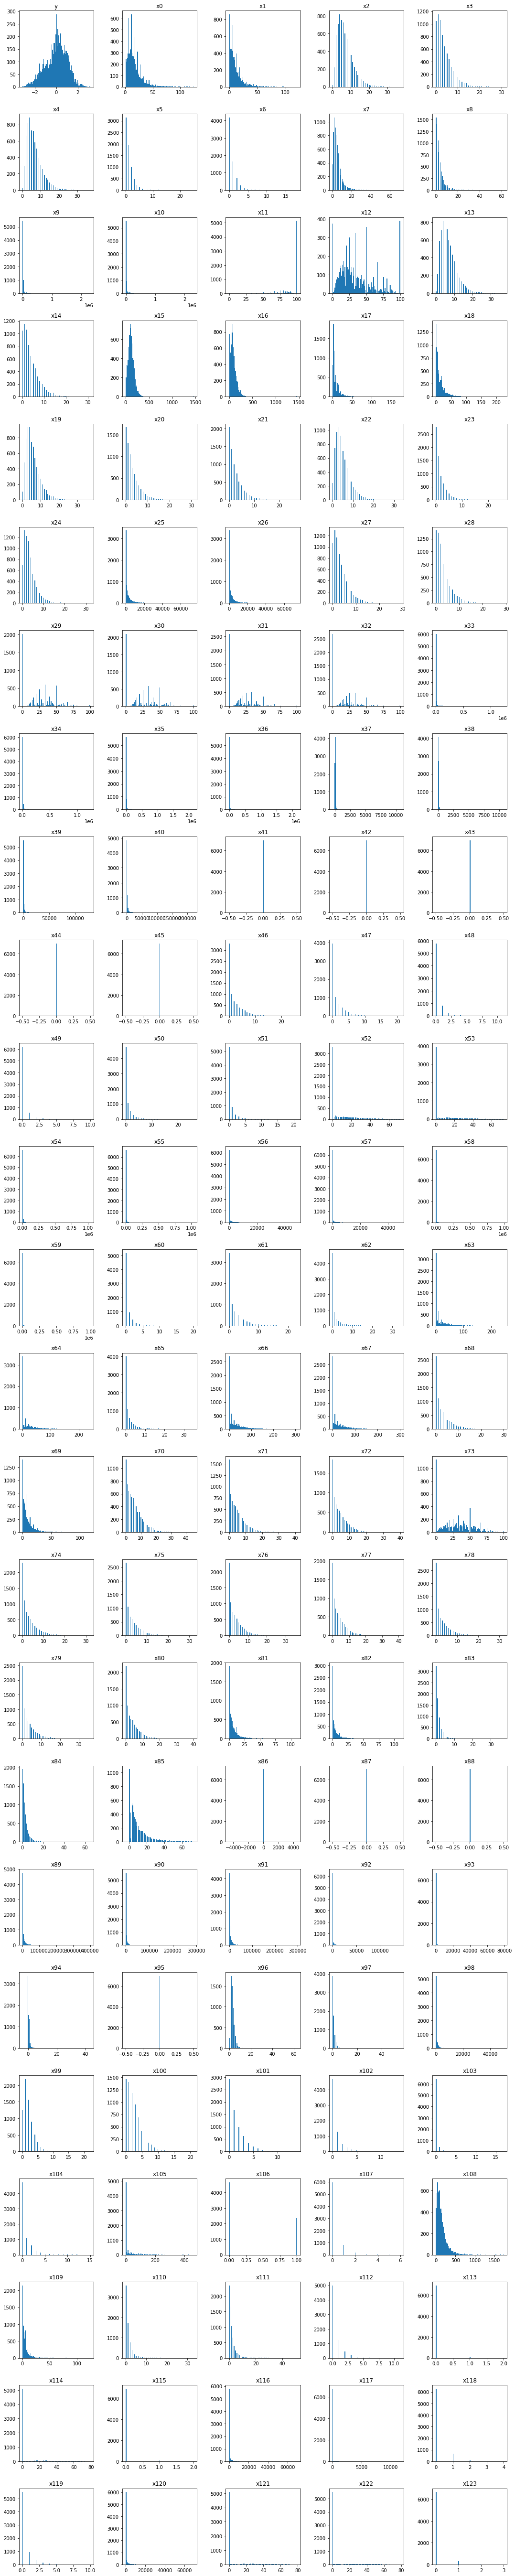

In [168]:
# Plot distributions of each feature
fig, ax = plt.subplots(nrows=25, ncols=5, figsize=(15,75))

ax = ax.reshape(-1)
for i in range(np.size(ax)):
    if i == 0:
        ax[i].hist(y_train0,bins=100)
        ax[i].set_title('y')
    else:
        ax[i].hist(X_train0[f'x{i-1}'],bins=100)
        ax[i].set_title(f'x{i-1}')

plt.tight_layout()

From the above plots we can see several features which are single-valued. These have no predictive power and can negatively impact the training of the model, so should be removed. We first identify these and plot the corresponding features in the test set to verify, before removing them:

Features to remove: [41, 42, 43, 44, 45, 87, 88, 95]


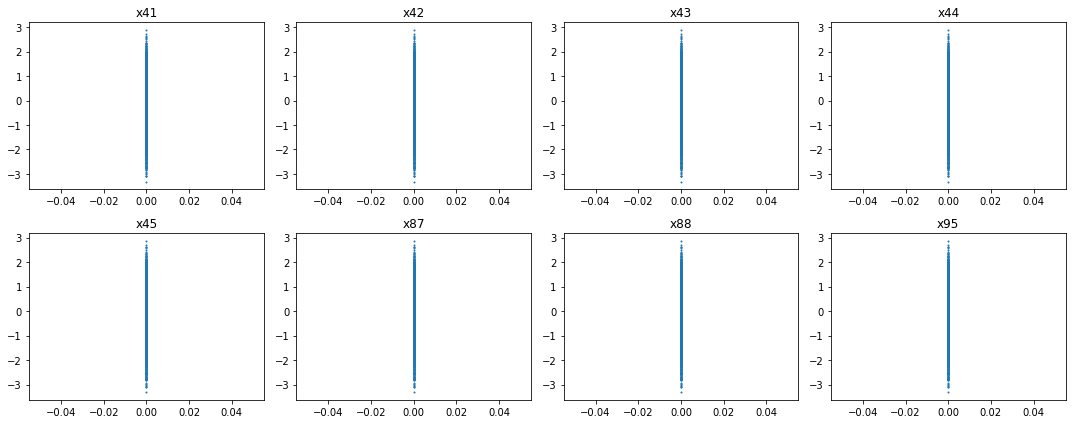

In [169]:
# If sigma = 0 the feature is single-valued
std_devs = X_train0.std(axis=0)
idx_remove = list((std_devs==0).to_numpy().nonzero()[0])
print(f'Features to remove: {idx_remove}')

fig, ax = plt.subplots(nrows=int(np.ceil(np.size(idx_remove)/4)), ncols=4, figsize=(15,6))
ax = ax.reshape(-1)

for i in range(np.size(ax)):
    if i>=np.size(idx_remove):
        break
        
    ax[i].scatter(X_test0[f'x{idx_remove[i]}'],y_test0, s=1)
    ax[i].set_title(f'x{idx_remove[i]}')

plt.tight_layout()

Feature 86 also looks a bit suspicious. However, it has a similar distribution in the test set so we will leave it in the training set:

Text(0.5, 1.0, 'x86')

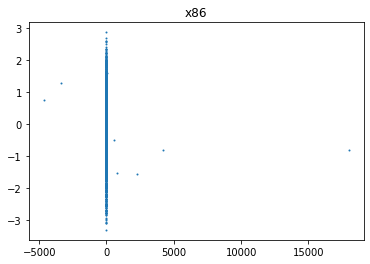

In [209]:
plt.scatter(X_test0['x86'],y_test0,s=1)
plt.title('x86')

In [210]:
# Delete identified features in train and test sets
delete_list = [f'x{idx}' for idx in idx_remove]

X_train1 = X_train0.drop(columns=delete_list)
X_test1 = X_test0.drop(columns=delete_list)


We will not ingestigate some suspicious samples visible in the charts.

x113 and x115 are binary except for one sample each taking on the value 2, which may be an entry error. It turns out these both belong to the same sample. Since the dataset is large we can safely delete this sample.

In [211]:
tmp = X_train1[X_train1['x115'] == 2]
print(f'{len(tmp)} samples found with x115 == 2')
print(f'Corresponding value of x113: {tmp["x113"].iloc[0]}')

# Delete suspicious sample
y_train1 = y_train0.drop(index=X_train1[X_train1['x115'] == 2].index, inplace=False)
X_train1.drop(index=X_train1[X_train1['x115'] == 2].index, inplace=True)


1 samples found with x115 == 2
Corresponding value of x113: 2.0


__Now we train an initial model to benchmark unchanged data performance__

Since this is a regression problem to predict a continuous variable, an ANN architecture was chosen. The initial model is quite basic - all layers are fully connected, there are two hidden layers, the first with a number of neurons equal to ~2/3 the number of features, and the second with an intermediate number between the number in layer h1 and the number in the output layer. The output layer contains only 1 neuron as this is a single-value prediction problem.

ReLU activation functions were used on both hidden layers as it enables modelling nonlinearities while also being very fast to train with. Linear activation was chose for the output as the output values can be positive or negative and are not bounded to -1 <= y <= 1, thus sigmoid-type functions would be unsuitable. The common mean-squared-error loss function was used to measure the quality of the model's predictions. Although the next question penalises the absolute error in prediction, MSE is more suitable for gradient descent than MAE due to the decreasing gradient close to the minimum. Since we are dealing with price prediction, a custom loss function was considered which would penalise positive and negative errors differently to minimise losses on trades. However, the question asks to only minimise the absolute error and build a model which predicts the true price movement's value as accurately as possible, so this was not implemented. However, it might be worth investigating training two models which are specialised in predicting positive and negative movements more accurately, depending if a long or short position is to be opened. Min-max scaling was applied to ensure all features exist on the same scale of 0-1.

The model is trained in mini-batch mode. Although the dataset is small and fits into GPU memory easily, batch mode still risks getting stuck in a local minimum of loss. A batch size ~5-10% of the training set size was used to keep training time low, while not making the loss curve too unstable.

Training...


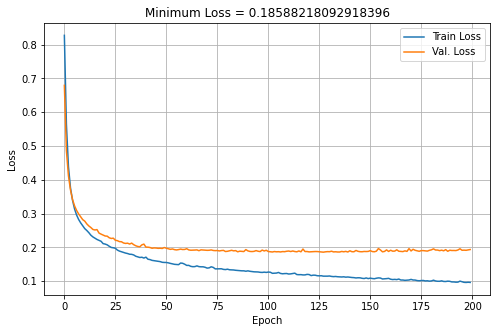

In [174]:
# Apply min-max scaling to input features
scaler = MinMaxScaler()
scaler.fit(X_train1)
X_train_scaled = scaler.transform(X_train1)
X_test_scaled = scaler.transform(X_test1)

in_dim = np.size(X_train_scaled[0, :])

def build_model():
    model = Sequential()
    model.add(Dense(75, input_dim=in_dim, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model


model = KerasRegressor(build_fn=build_model,
                       epochs=200,
                       batch_size=512,
                       verbose=0,
                       validation_data=(X_test_scaled, y_test0))


print('Training...')
history = model.fit(X_train_scaled, y_train1)

df = pd.DataFrame(history.history)
ax = df['loss'].plot(figsize=(8, 5), label='Train Loss')
df['val_loss'].plot(figsize=(8, 5), label='Val. Loss')

ax.legend()
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.grid(True)
ax.set_title(f'Minimum Loss = {df["val_loss"].min()}')
plt.show()

The initial benchmark model converged to ~0.185 loss. Will now try to improve on this through feature selection, train set processing and hyperparameter tuning.

We first investigate the correlation between features by plotting a heatmap of the correlation matrix.

<AxesSubplot:>

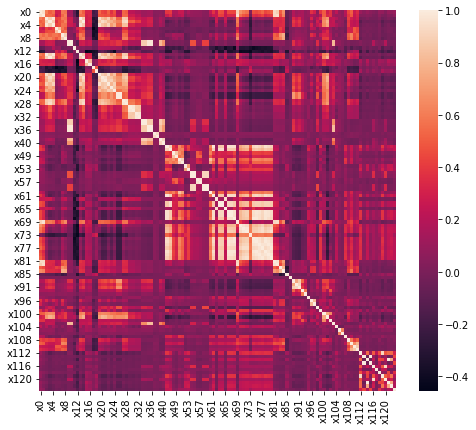

In [175]:
cmatrix = X_train1.corr()

plt.figure(figsize=(8,7))
sb.heatmap(cmatrix, annot=False)

It is clear there are some strong correlations between features in the training set. Removing some of these and training on the rest (feature selection) may yield an improved model by removing redundant data. A threshold can be set which, if a feature is found to be correlated with another feature with coefficient > threshold, that feature will be removed from both the training and test sets. The model can then be retained and compared with the model containing all features.

(0.0, 0.25)

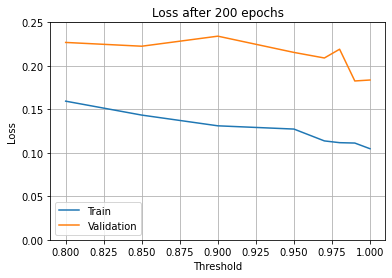

In [177]:
result = []   

for threshold in [0.8, 0.85, 0.9, 0.95, 0.97, 0.98, 0.99, 1]:
    
    # Use only the upper triangle of the correlation matrix to avoid double-counting
    upper_triangle = cmatrix.where(np.triu(np.ones(cmatrix.shape),k=1).astype('bool'))

    to_remove = [col for col in upper_triangle.columns if any(upper_triangle[col] >= threshold)]

    X_train2 = X_train1.drop(columns=to_remove).copy()
    X_test2 = X_test1.drop(columns=to_remove).copy()

    scaler = MinMaxScaler()
    scaler.fit(X_train2)
    X_train_scaled = scaler.transform(X_train2)
    X_test_scaled = scaler.transform(X_test2)

    in_dim = np.size(X_train_scaled[0, :])


    model = KerasRegressor(build_fn=build_model,
                           epochs=200,
                           batch_size=512,
                           verbose=0,
                           validation_data=(X_test_scaled, y_test0))


    print(f'Training model for threshold = {threshold}')
    history = model.fit(X_train_scaled, y_train1)

    df = pd.DataFrame(history.history)
    result.append([threshold, df['loss'].iloc[-1], df['val_loss'].iloc[-1]])


# Plot results
result = np.array(result)
plt.plot(result[:,0], result[:,1], label='Train')
plt.plot(result[:,0], result[:,2], label='Validation')
plt.title('Loss after 200 epochs')
plt.xlabel('Threshold')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.ylim([0, 0.25])


After testing different threshold values, it was found that setting the threshold to less than ~0.99 resulted in significantly increased loss as can be seen in the above figure. Since the goal is accuracy, and there was no meaningful change in training speed with fewer features, we only remove features which were perfectly correlated with another (threshold = 1).

Next we look at possible missing values. Some features contain lots of zero entries which do not appear to fit with the rest of the feature's distribution. It is unknown if this is a missing value imputation or a genuine reading. If they are indeed missing values replaced by zero, using a better imputation method should yield improved model fitting. We will attempt this imputation using k-nearest-neighbours. First the problem features are identified and plotted, then the imputation is applied, and the model retrained.

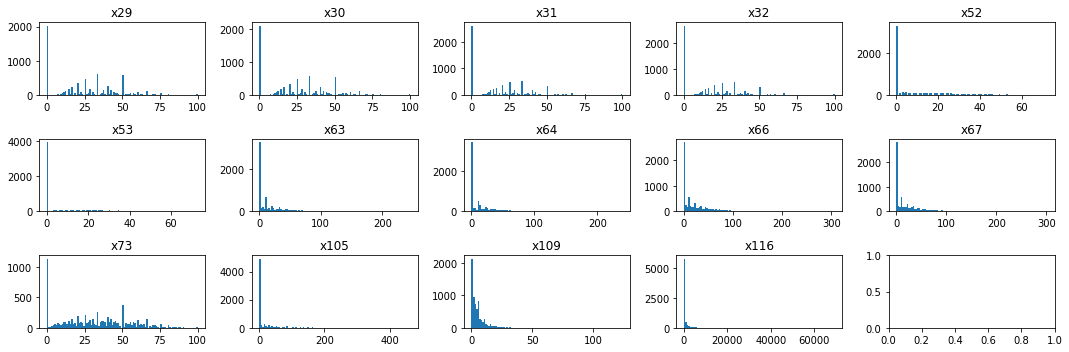

In [179]:
X_train_knn = copy.deepcopy(X_train2)
X_test_knn = copy.deepcopy(X_test2)

# Plot the features to investigate
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,5))

to_investigate = ['x29', 'x30', 'x31', 'x32', 'x52', 'x53', 'x63', 'x64', 'x66', 'x67', 'x73', 'x105', 'x109', 'x116' ]

ax = ax.reshape(-1)
for i in range(np.size(to_investigate)):
    ax[i].hist(X_train_knn[f'{to_investigate[i]}'],bins=100)
    ax[i].set_title(f'{to_investigate[i]}')

plt.tight_layout()

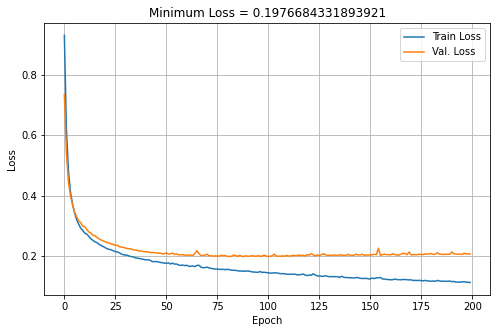

In [191]:
imputer = KNNImputer(missing_values=0, n_neighbors=500)

for feature in to_investigate:
    X_train_knn[feature] = imputer.fit_transform(X_train_knn[feature].to_numpy().reshape(-1,1))
    X_test_knn[feature] = imputer.fit_transform(X_test_knn[feature].to_numpy().reshape(-1,1))



# Retrain model for comparison

scaler = MinMaxScaler()
scaler.fit(X_train_knn)
X_train_scaled = scaler.transform(X_train_knn)
X_test_scaled = scaler.transform(X_test_knn)

in_dim = np.size(X_train_scaled[0, :])


model = KerasRegressor(build_fn=build_model,
                       epochs=200,
                       batch_size=512,
                       verbose=0,
                       validation_data=(X_test_scaled, y_test0))


history = model.fit(X_train_scaled, y_train1)

df = pd.DataFrame(history.history)
ax = df['loss'].plot(figsize=(8, 5), label='Train Loss')
df['val_loss'].plot(figsize=(8, 5), label='Val. Loss')

ax.legend()
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Minimum Loss = {df["val_loss"].min()}')
ax.grid(True)
plt.show()


This has caused a slight reduction in performance as measured by the validation loss. This may indicate that these particular features are indeed genuine readings, but perhaps of relatively low importance. Since this step did not improve the fit, the dataset is reverted to the previous version before continuing.

Some features appear to be integer-only. It is unknown if these are categorical or not, so we will now attempt to identify categorical features and replace them with one-hot encoded representations.

In [181]:
def is_int_array(x):
    # Determines if all elements in an np.ndarray are integers
    if np.max(np.abs(x - x.astype('int'))) > 0 :
        return False
    else:
        return True


feature_info = pd.DataFrame()
for i in range(X_train2.shape[1]):
    feature_info.loc[X_train2.columns[i], 'is_int_only'] = is_int_array(X_train2.iloc[:,i])

print(f'{feature_info["is_int_only"].sum()} integer-valued features found')

101 integer-valued features found


Since lots of integer-valued features are present, it is unlikely they are all categorial. Instead we will try looking for integer datatypes:

In [182]:
for i in range(X_train2.shape[1]):
    feature_info.loc[X_train2.columns[i], 'is_int64'] = X_train2[X_train2.columns[i]].dtype == 'int64'

tmp = feature_info['is_int64'].sum()

print(f'{tmp} int64 type features found')

7 int64 type features found


7 features were found to have type int64. We will now investigate these features more closely:

Variables of type int64: ['x105' 'x106' 'x107' 'x108' 'x109' 'x110' 'x111']


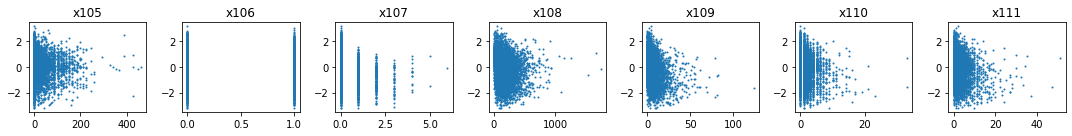

In [183]:
labels_int64 = feature_info[feature_info['is_int64']].index

print(f'Variables of type int64: {labels_int64.values}')

# Display the identified features
fig, ax = plt.subplots(nrows=1, ncols=7, figsize = (15,2))

ax = ax.flatten()

for i in range(len(ax)):
    ax[i].scatter(X_train2[labels_int64.values[i]], y_train1, s=1)
    ax[i].set_title(labels_int64.values[i])

plt.tight_layout()

Of these, only x106 and x107 appear to be (possibly) categorical due to the small number of discrete values they assume. x106 is binary and so needs no modification. We will replace x107 with a one-hot encoding and retest the model.

Unique values of x107 in test set: [0, 2, 1, 4, 3, 7, 5]


Text(0.5, 1.0, 'x107 (test set)')

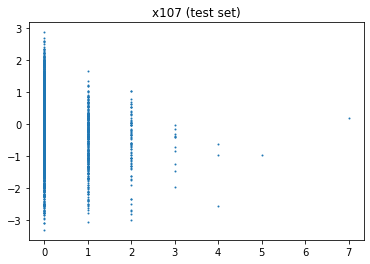

In [184]:
print(f'Unique values of x107 in test set: {list(X_test2["x107"].unique())}')
plt.scatter(X_test2['x107'],y_test0,s=1)
plt.title('x107 (test set)')

The test set contains one sample with x107=7 while the training set only contains values up to 6. Since we are (for now) treating this feature as categorical, we will remove this sample as the training set does not represent the (possible) category x107=7.

In [185]:
# Remove the sample with x107=7
idx_drop = X_test2[X_test2['x107']==7].index
X_test3 = X_test2.drop(index=idx_drop).copy()
y_test3 = y_test0.drop(index=idx_drop).copy()

X_train3 = X_train2.copy()

In [186]:
# Convert x107 into one-hot encoded categorical features in both train and test sets
ohe = OneHotEncoder()
X1 = X_train3['x107'].to_numpy().reshape(-1,1)
onehot_train = ohe.fit_transform(X1).toarray()

X2 = X_test3['x107'].to_numpy().reshape(-1,1)
onehot_test = ohe.fit_transform(X2).toarray()

# Create new feature names
col_names_train = [f'x107_{cat}' for cat in list(X_train3['x107'].unique())]
col_names_test = [f'x107_{cat}' for cat in list(X_test3['x107'].unique())]

# Create dataframes of the new one-hot features
onehot_train = pd.DataFrame(onehot_train,columns=col_names_train, index=X_train3.index)
onehot_test = pd.DataFrame(onehot_test,columns=col_names_test, index=X_test3.index)


In [187]:
# Check the new features for the train and test sets are the same, and correct any mismatches
print('New Features for train set:')
print(np.sort(col_names_train))
print('New Features for test set:')
print(np.sort(col_names_test))

# Fill unrepresented feature in test set
onehot_test['x107_6'] = 0

# Replace x107 with the new features
X_train3.drop(columns='x107', inplace=True)
X_train3 = pd.concat((X_train3, onehot_train), axis=1)

X_test3.drop(columns='x107', inplace=True)
X_test3 = pd.concat((X_test3, onehot_test), axis=1)

#Sort columns
X_train3 = X_train3.reindex(sorted(X_train3.columns), axis=1)
X_test3 = X_test3.reindex(sorted(X_test3.columns), axis=1)

New Features for train set:
['x107_0' 'x107_1' 'x107_2' 'x107_3' 'x107_4' 'x107_5' 'x107_6']
New Features for test set:
['x107_0' 'x107_1' 'x107_2' 'x107_3' 'x107_4' 'x107_5']


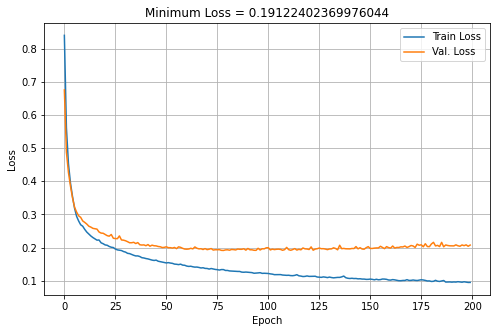

In [192]:
# Retrain model with processed dataset

# Apply min-max scaling to input features
scaler = MinMaxScaler()
scaler.fit(X_train3)
X_train_scaled = scaler.transform(X_train3)
X_test_scaled = scaler.transform(X_test3)

in_dim = np.size(X_train_scaled[0, :])

model = KerasRegressor(build_fn=build_model,
                       epochs=200,
                       batch_size=512,
                       verbose=0,
                       validation_data=(X_test_scaled, y_test3))



history = model.fit(X_train_scaled, y_train1)


df = pd.DataFrame(history.history)
ax = df['loss'].plot(figsize=(8, 5), label='Train Loss')
df['val_loss'].plot(figsize=(8, 5), label='Val. Loss')

ax.legend()
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Minimum Loss = {df["val_loss"].min()}')
ax.grid(True)
plt.show()

Again, this processing has yielded a model that converges to similar/slightly worse validation loss. Since we had to remove samples for no gain (and were unsure if x107 was categorical or not), we again revert to the previous version of the dataset.

We will now attempt to identify and remove outlier samples in the training set using an isolation forest, which may yield an improved fit.

In [189]:
forest = IsolationForest()

idx_outlier = (forest.fit_predict(X_train1) == -1)
idx_outlier = X_train1.iloc[idx_outlier,:].index

print(f'Removing {len(idx_outlier)} outliers.')

X_train_IF = X_train1.drop(index=idx_outlier)
y_train_IF = y_train1.drop(index=idx_outlier)

Removing 355 outliers.


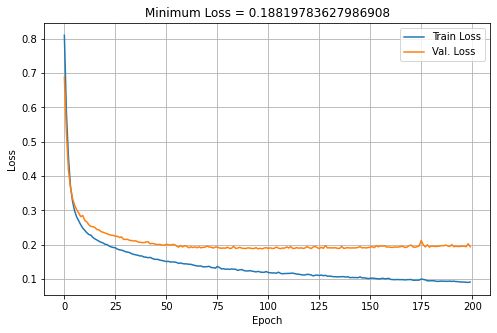

In [193]:
# Apply min-max scaling to input features
scaler = MinMaxScaler()
scaler.fit(X_train_IF)
X_train_scaled = scaler.transform(X_train_IF)
X_test_scaled = scaler.transform(X_test1)

in_dim = np.size(X_train_scaled[0, :])

model = KerasRegressor(build_fn=build_model,
                       epochs=200,
                       batch_size=512,
                       verbose=0,
                       validation_data=(X_test_scaled, y_test0))

history = model.fit(X_train_scaled, y_train_IF)

df = pd.DataFrame(history.history)
ax = df['loss'].plot(figsize=(8, 5), label='Train Loss')
df['val_loss'].plot(figsize=(8, 5), label='Val. Loss')

ax.legend()
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Minimum Loss = {df["val_loss"].min()}')
ax.grid(True)
plt.show()

Although some outliers were identified and removed, once again we have gained no improvement to the validation performance, and changes are reverted.

As we have attempted many processing steps on the data to no avail, we conclude that the data is clean and genuine, and turn our attention to the model itself. We will tune model hyperparameters to attempt to find an architecture which outperforms the baseline model.

We start by testing the number of units in each hidden layer, and the activation function used in each hidden layer. Only combinations of ReLU and tanh activations were tested. Other common activation functions such as sigmoid or softmax are not capable of reaching zero when the inputs have been min-max scaled

We will perform the hyperparameter tuning on a subset of the training set to prevent overfitting to the test set and produce a more generalised model.

In [194]:
# Create test set
X_train3, X_val, y_train3, y_val = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

# Scale input features
scaler = MinMaxScaler()
scaler.fit(X_train3)
X_train_scaled = scaler.transform(X_train3)
X_val_scaled = scaler.transform(X_val)

in_dim = np.size(X_train_scaled[0, :])

def build_model_tuning(params):
    model = Sequential()
    for i in range(params['n_hidden']):
        if i == 0:
            model.add(Dense(units=params[f'units_h{i}'], input_dim=in_dim, activation=params[f'act_h{i}']))
        else:
            model.add(Dense(units=params[f'units_h{i}'], activation=params[f'act_h{i}']))
    
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model


# Set up grid of hyperparameters to search
u0 = np.arange(50,150,step=25)
act = ['relu', 'tanh']
u1 = np.arange(10,30,step=10)

n_models = len(u0)*len(act)*len(act)*len(u1)
history = []
hp = []

count = 0
for a in u0:
    for b in act:
        for c in u1:
            for d in act:
                p = {'n_hidden' : 2,
                    'units_h0': a,
                     'act_h0': b,
                     'units_h1': c,
                     'act_h1' : d
                    }
                count+=1
                print(f'Model {count}/{n_models}')
                
                # Build a different model for each combination of hyperparameters
                model = KerasRegressor(build_fn= lambda: build_model_tuning(p),
                       epochs=500,
                       batch_size=512,
                       verbose=0,
                       validation_data=(X_val_scaled, y_val))
                
                # Save train history for each model
                history.append(model.fit(X_train_scaled, y_train3))
                hp.append(p)
                



Model 1/32
Model 2/32
Model 3/32
Model 4/32
Model 5/32
Model 6/32
Model 7/32
Model 8/32
Model 9/32
Model 10/32
Model 11/32
Model 12/32
Model 13/32
Model 14/32
Model 15/32
Model 16/32
Model 17/32
Model 18/32
Model 19/32
Model 20/32
Model 21/32
Model 22/32
Model 23/32
Model 24/32
Model 25/32
Model 26/32
Model 27/32
Model 28/32
Model 29/32
Model 30/32
Model 31/32
Model 32/32


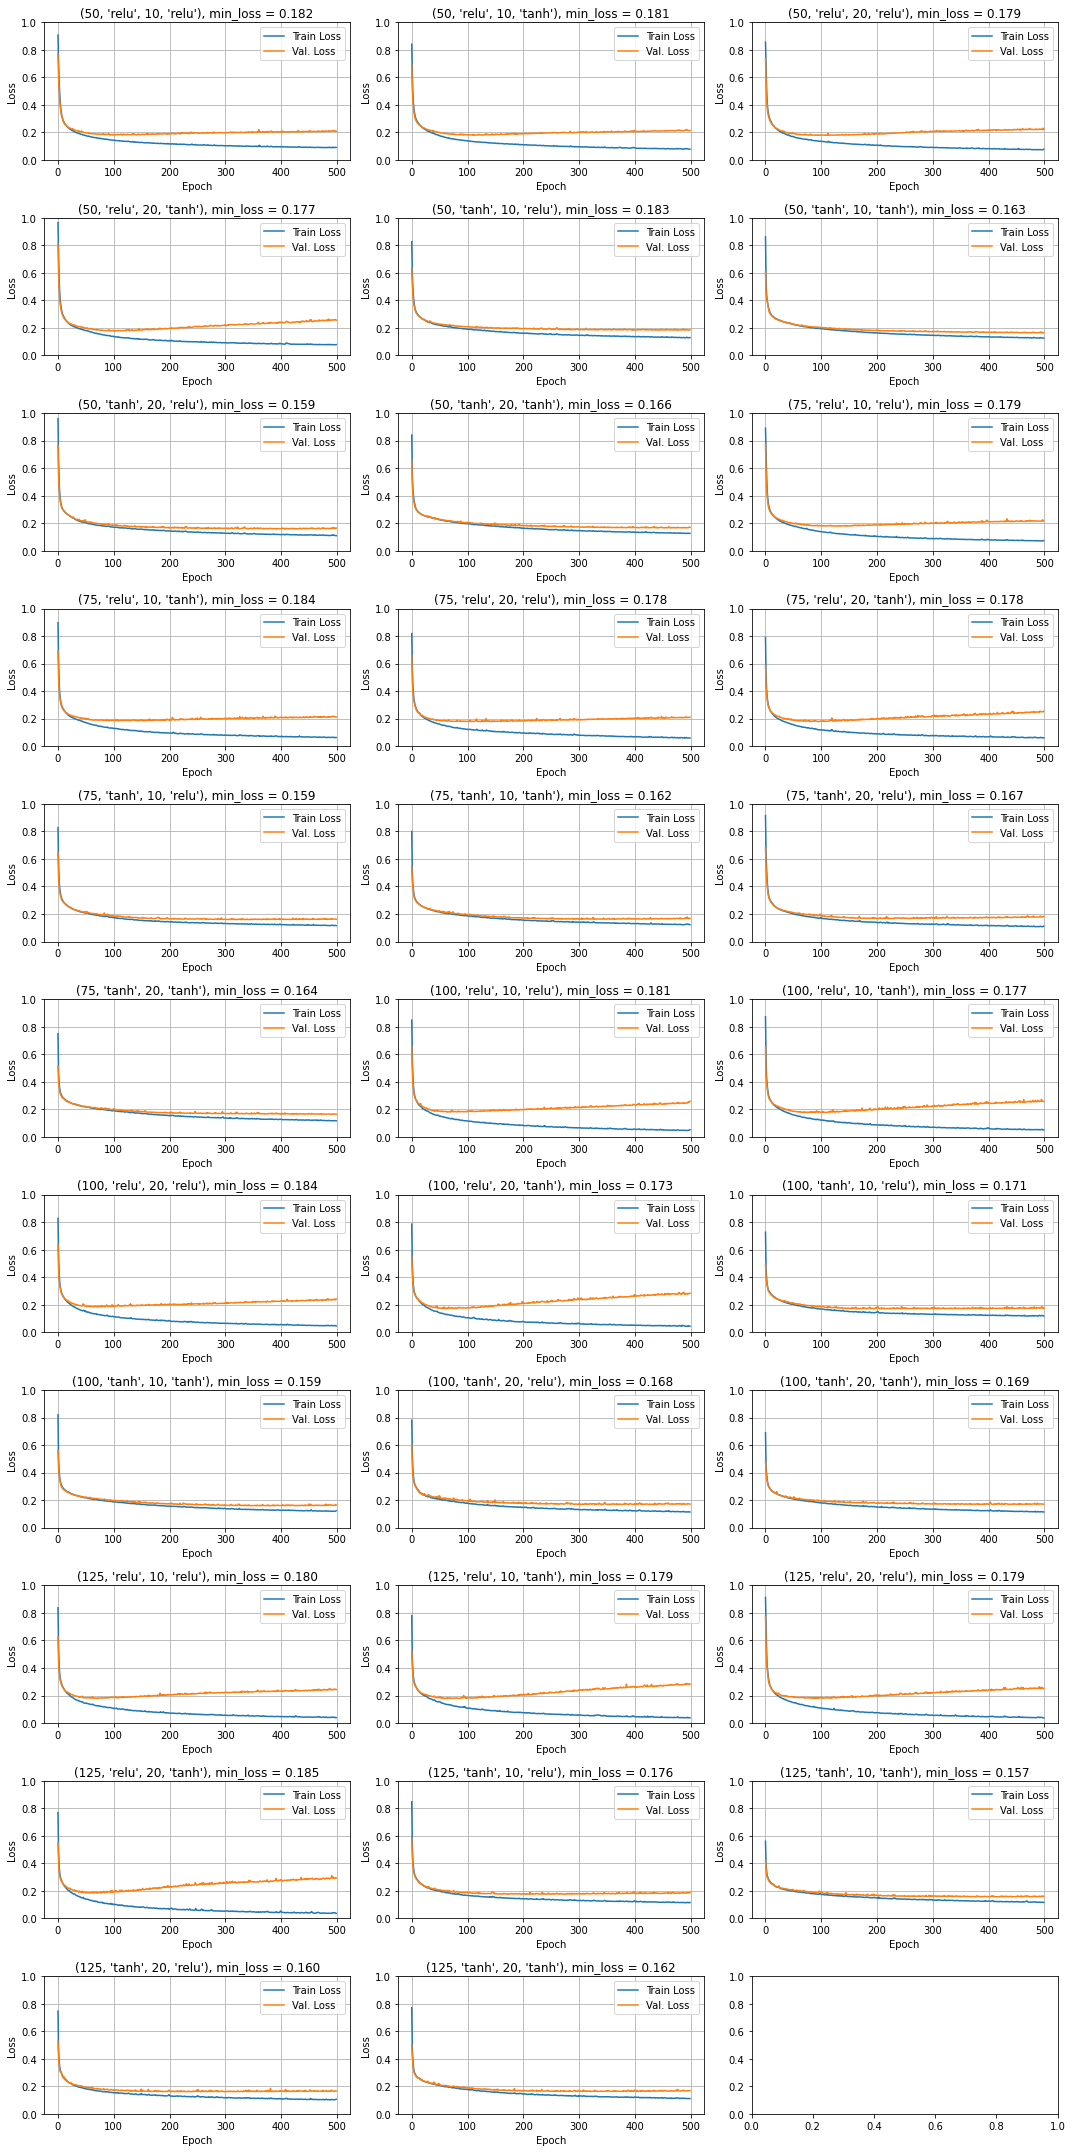

In [195]:
fig, ax = plt.subplots(nrows=int(np.ceil(len(history)/3)),
                       ncols=3,
                       figsize=(15,30))

ax = ax.flatten()

for i in range(len(history)):
    df = pd.DataFrame(history[i].history)
    ax[i].plot(df['loss'], label='Train Loss')
    ax[i].plot(df['val_loss'], label='Val. Loss')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss')
    ax[i].set_title(f'{hp[i]["units_h0"], hp[i]["act_h0"], hp[i]["units_h1"], hp[i]["act_h1"],}, min_loss = {df["val_loss"].min():.3f}')
    ax[i].set_ylim([0,1])

fig.tight_layout()

It is clear from these results that models using ReLU in any capacity perform worse than dual tanh models, training faster but reaching a higher minimum in validation loss. Additionally, some dual tanh models appear to still be improving after 500 epochs. We select a dual tanh model and continue to tweak the width and depth of hidden layers.

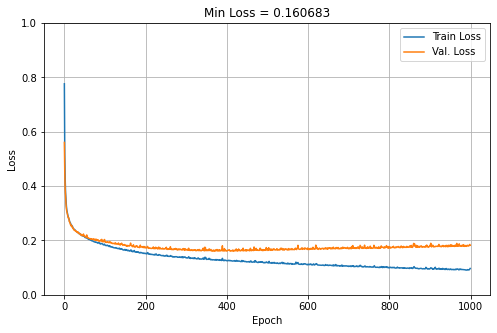

In [196]:
# Retrain model for comparison

def build_model():
    model = Sequential()
    model.add(Dense(125, activation='tanh'))
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model


model = KerasRegressor(build_fn=build_model,
                       epochs=1000,
                       batch_size=512,
                       verbose=0,
                       validation_data=(X_val_scaled, y_val))



history = model.fit(X_train_scaled, y_train3)


df = pd.DataFrame(history.history)
ax = df['loss'].plot(figsize=(8, 5), label='Train Loss')
df['val_loss'].plot(figsize=(8, 5), label='Val. Loss')

ax.legend()
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.title(f'Min Loss = {df["val_loss"].min():3f}')
ax.grid(True)
ax.set_ylim([0,1])
plt.show()


After manually tuning hyperparameters to test wider layers as well as an additional hidden layer, it was found that no tested models were able to beat ~0.160-165 loss, which was attained using 125/10 layers, both with tanh activation. Several other networks came close, however this was the best performing model. This is the final model which we will use for the remainder of the question.

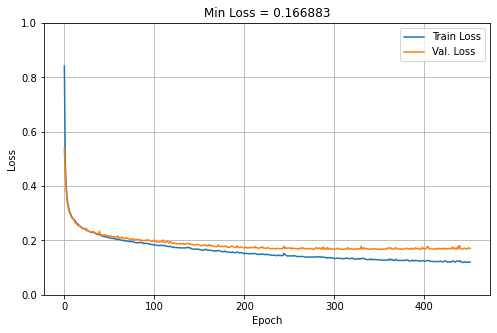

In [197]:
# Retrain to the optimal number of epochs using early stopping
final_model = KerasRegressor(build_fn=build_model,
                       epochs=1000,
                       batch_size=512,
                       verbose=0,
                       validation_data=(X_val_scaled, y_val))


# Early stopping stops the training after no more improvements are being
# made and restores the weights that gave best performance
history = final_model.fit(X_train_scaled,
                          y_train3,
                          callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                     mode='min',
                                                                     min_delta=0.001,
                                                                     patience=100,
                                                                     restore_best_weights=True))

df = pd.DataFrame(history.history)
ax = df['loss'].plot(figsize=(8, 5), label='Train Loss')
df['val_loss'].plot(figsize=(8, 5), label='Val. Loss')

ax.legend()
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.title(f'Min Loss = {df["val_loss"].min():3f}')
ax.grid(True)
ax.set_ylim([0,1])
plt.show()

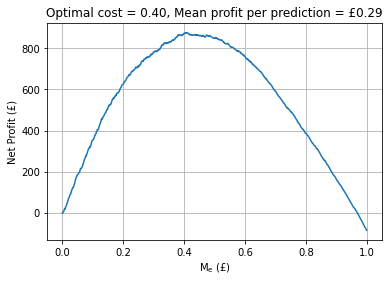

In [198]:
X_test_scaled = scaler.transform(X_test1)
y_pred = final_model.predict(X_test_scaled)

# Define a function to play the game in a single line
def play_game(predictions, truths, M_e):
    # Returns the net profit of all predictions given cost per prediction M_e
    
    err = np.abs(predictions - truths)
    profit = (err<=M_e).sum()
    
    # Assuming you still pay the cost if your error is > M_e
    total_cost = M_e*np.size(y_pred)

    return profit-total_cost

# 1D grid search over M_e to find the maximum in the range [0,1)
result = []
for cost in np.arange(0,1,step=0.001):
    result.append([cost, play_game(y_pred, y_test0, cost)])

result = np.array(result)

optimal_cost = result[result[:,1]==np.max(result[:,1]),0][0]
avg_profit = result[result[:,1]==np.max(result[:,1]),1][0] / np.size(y_pred)

plt.plot(result[:,0],result[:,1])
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.xlabel('$M_e$ (£)')
plt.ylabel('Net Profit (£)')
plt.title(f'Optimal cost = {optimal_cost:.2f}, Mean profit per prediction = £{avg_profit:.2f}')
plt.grid(True)

Using the final model, an optimum cost of 0.40 has been identified via a 1D grid search, with a mean profit per prediction of £0.29.

We now consider improvements to the model. We first visualise the errors in prediction:

Mean error = -0.010008171654863172
Error variance = 0.1830828446166322


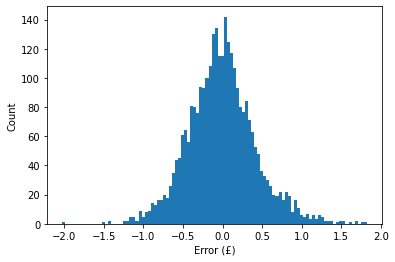

In [199]:
err = y_pred-y_test0

plt.hist(err, bins=100)
plt.xlabel('Error (£)')
plt.ylabel('Count')
print(f'Mean error = {np.mean(err)}')
print(f'Error variance = {np.var(err)}')

As can be seen, the developed model has a low bias as the mean error is close to zero, and a high variance. Efforts should be focussed on reducing the variance in the predictions while keeping the bias low.

If the game is identical, the only way to increase profits is to decrease the average error in the predictions. This allows M_e to be set at a lower value and thus increases profits, as shown below:

Text(0.5, 1.0, 'Average profit vs error reduction factor')

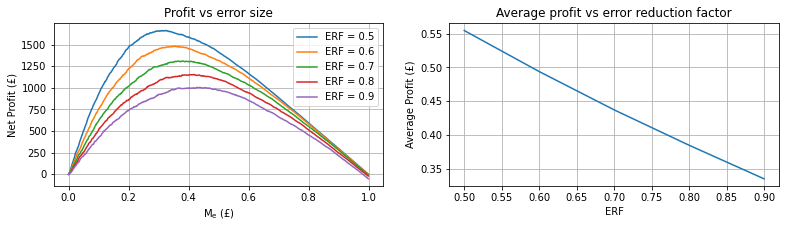

In [200]:
def play_game_modified(predictions, truths, M_e, err_reduction_factor):
    # Added a factor which reduces the error magnitudes
    err = err_reduction_factor*np.abs(predictions - truths)
    profit = (err<=M_e).sum()
    
    total_cost = M_e*np.size(y_pred)
    return profit-total_cost

fig, ax = plt.subplots(ncols=2, figsize=(13,3))
result2 = []
for ERF in np.arange(0.5,1,0.1):
    result = []
    for cost in np.arange(0,1,step=0.001):
        result.append([cost, play_game_modified(y_pred, y_test0, cost, ERF)])

    result = np.array(result)

    optimal_cost = result[result[:,1]==np.max(result[:,1]),0][0]
    avg_profit = result[result[:,1]==np.max(result[:,1]),1][0] / np.size(y_pred)

    ax[0].plot(result[:,0],result[:,1], label=f'ERF = {ERF:.1f}')
    result2.append([ERF, avg_profit])
           
plt.rcParams.update({'mathtext.default': 'regular' })
ax[0].set_xlabel('$M_e$ (£)')
ax[0].set_ylabel('Net Profit (£)')
ax[0].set_title(f'Profit vs error size')
ax[0].legend()
ax[0].grid(True)

result2 = np.array(result2)
ax[1].plot(result2[:,0],result2[:,1])
ax[1].set_xlabel('ERF')
ax[1].set_ylabel('Average Profit (£)')
ax[1].grid(True)
ax[1].set_title(f'Average profit vs error reduction factor')

It can be seen that as ERF decreases (average error is smaller), the total net profit and average profit per prediction both increase.

If the model is deployed and trades are made based on its predictions, the most obvious way to increase performance in future would be to continually expand the training set as trades are made, and periodically retrain the model using the new, larger batch of training data. If we move 2000 samples from the test set into the train set, for example, simulating periodically updating the model as new data comes in, we can see increased performance:

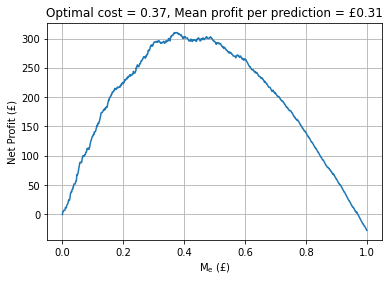

In [220]:
N = 2000
tmp = X_test1.iloc[:N,:].to_numpy()
X_train2 = np.vstack((X_train1, tmp))
X_test2 = X_test1.to_numpy()[N:,:]

y_train2 = np.hstack((y_train1.to_numpy(),y_test0.to_numpy()[:N]))
y_test2 = y_test0.to_numpy()[N:]

X_train2, X_val, y_train2, y_val = train_test_split(X_train2, y_train2, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train2)
X_train_scaled = scaler.transform(X_train2)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test2)

# Retrain
updated_model = KerasRegressor(build_fn=build_model,
                               epochs=1000,
                               batch_size=512,
                               verbose=0,
                               validation_data=(X_val_scaled, y_val))

history = updated_model.fit(X_train_scaled,
                            y_train2,
                            callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                       mode='min',
                                                                       min_delta=0.001,
                                                                       patience=100,
                                                                       restore_best_weights=True))

df = pd.DataFrame(history.history)
min_loss = df["val_loss"].min()

# Play game again with larger train set
y_pred = updated_model.predict(X_test_scaled)

result = []
for cost in np.arange(0,1,step=0.001):
    result.append([cost, play_game(y_pred, y_test2, cost)])

result = np.array(result)

optimal_cost = result[result[:,1]==np.max(result[:,1]),0][0]
avg_profit = result[result[:,1]==np.max(result[:,1]),1][0] / np.size(y_pred)
    
plt.plot(result[:,0],result[:,1])
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.xlabel('$M_e$ (£)')
plt.ylabel('Net Profit (£)')
plt.title(f'Optimal cost = {optimal_cost:.2f}, Mean profit per prediction = £{avg_profit:.2f}')
plt.grid(True)

With this larger test set, the mean profit per prediction is about 7% greater than before, indicating a more generalised model has been achieved through exposure to more samples. In this way, the model can be continually updated as more trades are performed. This approach assumes that market sentiment etc remains constant, which of course is not true in reality. To capture evolving market dynamics, older samples may be weighted less heavily in a weighted MSE loss function.